# Metodologia e resultados: visão geral

Com base nos dados disponibilizados pela Assembleia da República em
formato XML são criadas _dataframes_ (tabelas de duas dimensões) com
base no processamento e selecção de informação relativa aos padrões de
votação de cada partido (e/ou deputados não-inscritos).

Uma explicação mais detalhada dos processos pode ser obtida nos apêndices, o que se segue é uma introdução a algumas das análises fundamentais com base num exemplo fictício.

## As votações e os partidos

```{margin}
A conversão de votos em representações númericas pode ser feita de várias formas {cite}`hixDimensionsPoliticsEuropean2006`; adoptamos a abordagem de {cite:t}`krilaviciusStructuralAnalysisParliamentarian2008` no seu trabalho relativo às votações no parlamento lituano por nos parecer apropriada à realidade portuguesa:

* A favor: 1
* Contra: -1
* Abstenção: 0
* Ausência: 0

Este ponto é (mais um) dos que de forma relativamente opaca - pois raramente os detalhes têm a mesma projecção que os resultado finais - podem influenciar os resultados; cremos que em particular a equiparação entre abstenção e ausência merece alguma reflexão: considerámos que uma ausência em determinada votação tem um peso equivalente à abstenção, embora uma de forma passiva e outra activa.
```

Para simplificar usamos desde já valores numéricos, onde 1 = Favor, 0 = Abstenção, -1 = Contra, e não consideramos ausências. O processo de tratamento de dados reais irá, num dos seus passos, fazer esta transformação.

Considerem-se 4 partidos, para o nosso efeito denominados pelo sentido mais comum do seu voto; a seguinte tabela reflecte 10 votações e o comportamente de cada partido em cada uma delas

In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
%matplotlib inline

In [2]:
v5=[[1,1,1,1,1,1,1,1,1,1],[0,0,0,0,0,0,0,0,0,0],[1,0,0,0,1,1,0,1,0,1],[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]
v5_df = pd.DataFrame(v5, columns=["v1","v2", "v3","v4","v5","v6","v7","v8","v9","v10"], index=["Fav","Abst","Var","Cont"])
v5_df

v1  v2  v3  v4  v5  v6  v7  v8  v9  v10
Fav    1   1   1   1   1   1   1   1   1    1
Abst   0   0   0   0   0   0   0   0   0    0
Var    1   0   0   0   1   1   0   1   0    1
Cont  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1

## Mapa térmico das votações de todos os partidos

Um mapa térmico permite-nos visualizar os votos através de cores; é uma forma de observar os mesmos dados que os da tabela mas de forma gráfica, o que se neste caso não faz muita diferenças, passa a ser importante quando temos centenas de votações.

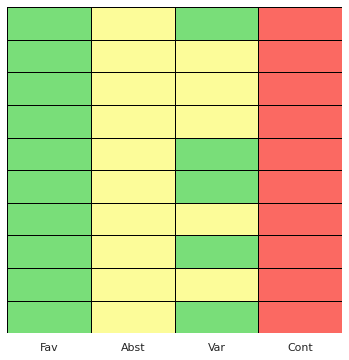

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


voting_palette = ["#FB6962","#FCFC99","#79DE79"]

fig = plt.figure(figsize=(6,6))
sns.heatmap(v5_df.T,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
            linecolor="black",
            linewidths=1
           )
plt.show()

## Matriz de distância

```{margin}
A matriz de distâncias é uma matriz quadradra $n\times n$ (onde _n_ é o número de partidos) e onde a distância entre _p_ e _q_ é o valor de $ d_{pq} $.

$ 
\begin{equation}
D= \begin{bmatrix} d_{11} & d_{12} & \cdots & d_{1 n} \\  d_{21} & d_{22} & \cdots & d_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ d_{31} & d_{32} & \cdots & d_{n n}   \end{bmatrix}_{\ n\times n}  
\end{equation}
$


A distância é obtida através da comparação de todas as observações de cada par usando uma determinada métrica de distância, sendo a distância euclideana bastante comum em termos gerais e também dentro de estudos sobre o mesmo domínio temático _(Krilavičius and Žilinskas 2008)_: cada elemento da matriz representa $ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$, equivalente, para dois pontos $P,Q $ , à mais genérica distância de Minkowski   $ D\left(P,Q\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{\frac {1}{p}} $ para $ p = 1$, mas note-se que a diagonal da matrix irá representar a distância entre um partido e ele próprio, logo $ d_{11} = d_{22} = \dots = d_{nn} = 0 $.
```

Uma matriz de distância apresenta o resultado das distâncias entre dois pontos - é o formato usado, por exemplo, para mostrar a distância entre vários pontos geográficos.

No caso de partidos e votações a distância é o resultado das diferenças entre sentidos de votos acumulados para todas as votações (de forma muito simples), e representada por uma matriz bidimensional onde quanto maior o número, mais distante está do par correspondente.

In [4]:
v5_distmat=pd.DataFrame(squareform(pdist(v5)), columns=v5_df.index, index=v5_df.index)
v5_distmat

Fav      Abst       Var      Cont
Fav   0.000000  3.162278  2.236068  6.324555
Abst  3.162278  0.000000  2.236068  3.162278
Var   2.236068  2.236068  0.000000  5.000000
Cont  6.324555  3.162278  5.000000  0.000000

A sua visualização (também através de um mapa térmico) permite ver rapidamente as proximidades através das cores utilizadas: quanto mais claro, mais distante. 

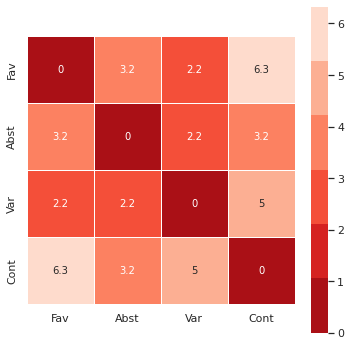

In [5]:
plt.figure(figsize=(6,6))

sns.heatmap(
    v5_distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
)
plt.show()

## Dendograma e _clustermap_

Com base nas distâncias segue-se o agrupamento (_clustering_); existem várias formas de o fazer e é preciso ter em consideração que o resultado obtido considera as distâncias entre todos os pares: é perfeitamente possível que elementos com maior distância aparecem agrupados de forma mais próxima devido à distância que cada um deles tem de todos os outros.

Dito isto, a visualização mais comum é um dendograma que apresenta uma "árvore" com diferentes ramos:

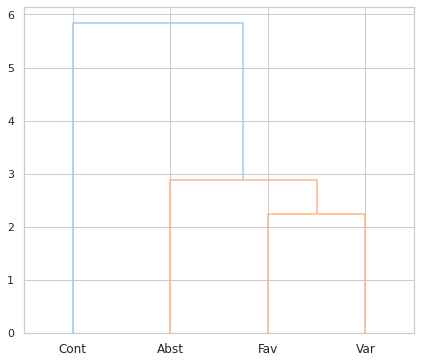

In [6]:
v5_distmat_link = hc.linkage(pdist(v5_df), method="ward")

from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(7,6))
dendrogram(v5_distmat_link, labels=v5_df.T.columns)
plt.show()

Um _clustermap_ é a combinação do mapa térmico de distância com o dendograma: as colunas e linhas são reordernadas e as linhas de agrupamento adicionadas.

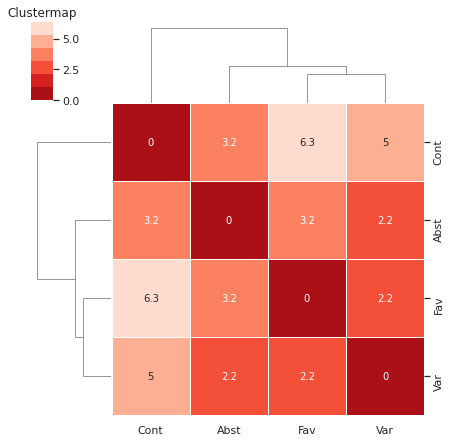

In [12]:
sns.clustermap(
    v5_distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    row_linkage=v5_distmat_link,
    col_linkage=v5_distmat_link,
    figsize=(6,6)
)
plt.title('Clustermap')

plt.show()

Como o _clustermap_ combina a informação de ambos será o mais utilizado.

## Multidimensional Scaling

Com base na matriz de distâncias podemos também visulizar a distância relativa entre todos os partidos através de _Multidimensional scaling_: com base na distância (acumulada) entre todos os pares determinam-se coordenadas em duas ou três dimensões (daí o nome, trata-se de reduzir as dimensões mantendo a distância relativa)

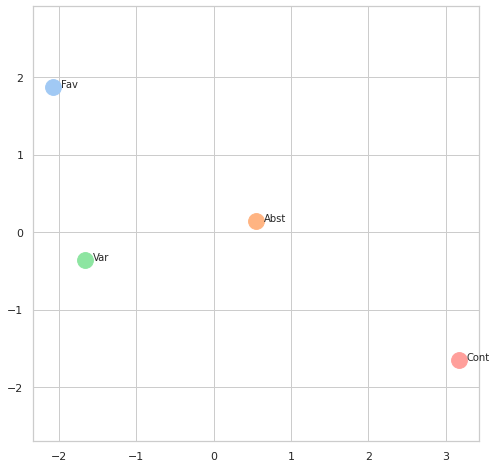

In [14]:
from sklearn.manifold import MDS
import random

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

results = mds.fit(v5_distmat.values)
coords = results.embedding_
fig, ax = plt.subplots(figsize=(8,8))

for label, x, y in zip(v5_distmat.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(
        label,
        xy = (x+0.1, y),
    )
plt.show()

```{margin}
A visualização do MDS tridimensional pode, dependendo do suporte, ser feita de forma interactiva.
```

Observe-se que não temos agrupamentos: MDS não é um método de _clustering_ mas sim de redução das dimensões de forma a manter as distâncias relativas entre os vários pontos, o que nos permite identificar visualmente possíveis grupos (e, neste caso, podemos ver como se relaciona com a matriz de distância obtida anteriormente). A redução das dimensões pode ser feita para 2 ou para 3, sendo nesse caso o resultado visualizável num cubo:

In [29]:
from sklearn.manifold import MDS
import random

mds = MDS(n_components=3, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

results = mds.fit(v5_distmat.values)
coords = results.embedding_

import plotly.graph_objects as go
from IPython.core.display import display, HTML
from plotly.offline import init_notebook_mode, plot
init_notebook_mode(connected=True)
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(v5_df.T.columns, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 800,
    height = 800,
    scene_aspectmode='cube',
    title = "3D MDS",
    template="plotly_white",
    showlegend=False
)
plot(fig, filename = 'intro_3d_mds.html')
display(HTML('intro_3d_mds.html'))